# Challenge 5 - Object Detection (with the Custom Vision Service)

In [1]:
# Download and extract image files
! curl -O https://computervisionhack.blob.core.windows.net/challengefiles/safety_images.zip
! unzip -o safety_images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  109M  100  109M    0     0  14.2M      0  0:00:07  0:00:07 --:--:-- 16.8M
Archive:  safety_images.zip
  inflating: safety_images/434140.jpg  
  inflating: safety_images/434502.jpg  
  inflating: safety_images/434922.jpg  
  inflating: safety_images/434947.jpg  
  inflating: safety_images/480835.jpg  
  inflating: safety_images/480836.jpg  
  inflating: safety_images/480837.jpg  
  inflating: safety_images/480839.JPG  
  inflating: safety_images/480840.jpg  
  inflating: safety_images/480863.jpg  
  inflating: safety_images/480864.jpg  
  inflating: safety_images/480869.jpg  
  inflating: safety_images/480884.jpg  
  inflating: safety_images/480894.jpg  
  inflating: safety_images/480910.jpg  
  inflating: safety_images/480942.jpg  
  inflating: safety_images/480979.jpg  
  inflating: safety_images/480980.jpg  
  inflating: sa

  inflating: safety_images/483077.JPG  
  inflating: safety_images/483085.jpg  
  inflating: safety_images/483148.JPG  
  inflating: safety_images/483153.JPG  
  inflating: safety_images/483160.jpg  
  inflating: safety_images/483190.JPG  
  inflating: safety_images/483200.jpg  
  inflating: safety_images/483245.JPG  
  inflating: safety_images/483267.jpg  
  inflating: safety_images/483269.jpg  
  inflating: safety_images/483270.jpg  
  inflating: safety_images/483274.jpg  
  inflating: safety_images/483277.jpg  
  inflating: safety_images/483285.jpg  
  inflating: safety_images/483295.JPG  
  inflating: safety_images/483303.JPG  
  inflating: safety_images/483304.JPG  
  inflating: safety_images/483326.JPG  
  inflating: safety_images/483327.JPG  
  inflating: safety_images/483366.JPG  
  inflating: safety_images/483367.JPG  
  inflating: safety_images/483382.JPG  
  inflating: safety_images/483426.jpg  
  inflating: safety_images/483448.jpg  
  inflating: safety_images/483449.jpg  


The tag files were created using the [VoTT](https://github.com/Microsoft/VoTT). To keep things simple, the following code just writes them as text files

In [2]:
%%writefile helmets.txt
safety_images/434922.jpg,303,179,358,212
safety_images/480980.jpg,2162,562,2354,710
safety_images/480986.jpg,850,1284,1089,1489
safety_images/480998.jpg,1205,434,1637,690
safety_images/481012.jpg,624,1275,979,1504
safety_images/481019.jpg,148,164,187,209
safety_images/481146.JPG,421,256,497,333
safety_images/481171.JPG,451,825,720,1094
safety_images/482767.JPG,696,247,1046,453
safety_images/482812.JPG,259,554,830,935
safety_images/482882.JPG,1732,793,1920,923
safety_images/483064.jpg,425,76,514,140
safety_images/483065.JPG,401,563,714,746
safety_images/483085.jpg,1579,158,2310,693
safety_images/483160.jpg,656,525,867,707
safety_images/483327.JPG,766,269,1089,572
safety_images/483448.jpg,637,252,827,394


Writing helmets.txt


In [3]:
%%writefile nohelmets.txt
safety_images/480942.jpg,43,116,1672,1470
safety_images/481018.jpg,936,531,1143,688
safety_images/481025.jpg,117,71,567,348
safety_images/481064.jpg,500,153,623,246
safety_images/481143.JPG,597,238,1280,624
safety_images/481216.JPG,1312,189,1449,273
safety_images/481220.jpg,51,45,264,230
safety_images/481252.JPG,97,186,378,341
safety_images/481405.JPG,395,72,478,129
safety_images/481758.JPG,914,740,1283,980
safety_images/481962.JPG,403,557,492,631
safety_images/482339.JPG,899,468,1104,607
safety_images/481340.JPG,889,1257,1450,1576
safety_images/481421.jpg,525,568,849,801
safety_images/483463.JPG,157,349,1778,506


Writing nohelmets.txt


Create an account at https://customvision.ai if you haven't already done so. Then modify the service keys below:

In [12]:
TRAINING_KEY = 'YOUR_TRAINING_KEY'
PREDICTION_KEY = 'YOUR_PREDICTION_KEY'
ENDPOINT='https://southcentralus.api.cognitive.microsoft.com' # If necessary, change to match your Azure service location

In [5]:
# Install the Custom Vision SDK
import sys
! {sys.executable} -m pip install azure-cognitiveservices-vision-customvision

In [6]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry, Region

trainer = CustomVisionTrainingClient(TRAINING_KEY, endpoint=ENDPOINT)

# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection")

# Create a new project
print ("Creating project...")
project = trainer.create_project("Safety Detection", domain_id=obj_detection_domain.id)

Creating project...


In [7]:
helmet_tag = trainer.create_tag(project.id, "Helmet")
nohelmet_tag = trainer.create_tag(project.id, "No_Helmet")
print('Created tags')

Created tags


In [8]:
def tag_images(txtFile, tag):
    import pandas as pd
    import numpy as np
    from matplotlib import image as mpimg

    print ("Tagging images from", txtFile)
    df=pd.read_csv(txtFile, sep=',',header=None)
    for row in df.values:
        file_name,l,t,r,b = row
        print(file_name)
        #normalize values
        img = mpimg.imread(file_name)
        img_h, img_w, img_ch = img.shape
        l = l / img_w
        r = r / img_w
        t = t/img_h
        b = b / img_h

        w = r-l
        h = b-t

        regions = [Region(tag_id=tag, left=l,top=t,width=w,height=h) ]

        with open(file_name, mode="rb") as image_contents:
            tagged_images_with_regions.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read(), regions=regions))


tagged_images_with_regions = []
tag_images('helmets.txt', helmet_tag.id)
tag_images('nohelmets.txt', nohelmet_tag.id)
print('Adding images to project...')
trainer.create_images_from_files(project.id, images=tagged_images_with_regions)


Tagging images from helmets.txt
safety_images/434922.jpg
safety_images/480980.jpg
safety_images/480986.jpg
safety_images/480998.jpg
safety_images/481012.jpg
safety_images/481019.jpg
safety_images/481146.JPG
safety_images/481171.JPG
safety_images/482767.JPG
safety_images/482812.JPG
safety_images/482882.JPG
safety_images/483064.jpg
safety_images/483065.JPG
safety_images/483085.jpg
safety_images/483160.jpg
safety_images/483327.JPG
safety_images/483448.jpg
Tagging images from nohelmets.txt
safety_images/480942.jpg
safety_images/481018.jpg
safety_images/481025.jpg
safety_images/481064.jpg
safety_images/481143.JPG
safety_images/481216.JPG
safety_images/481220.jpg
safety_images/481252.JPG
safety_images/481405.JPG
safety_images/481758.JPG
safety_images/481962.JPG
safety_images/482339.JPG
safety_images/481340.JPG
safety_images/481421.jpg
safety_images/483463.JPG
Adding images to project...


In [9]:
import time

print ("Training...")
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

# Set the default iteration
trainer.update_iteration(project.id, iteration.id, is_default=True)
print ("Done!")

perf = trainer.get_iteration_performance(project.id, iteration.id)
print('Performance by tag:')
for tag in perf.per_tag_performance:
    print (tag.name, '\n\tPrecision:',tag.precision, '\n\tRecall:', tag.recall)

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training


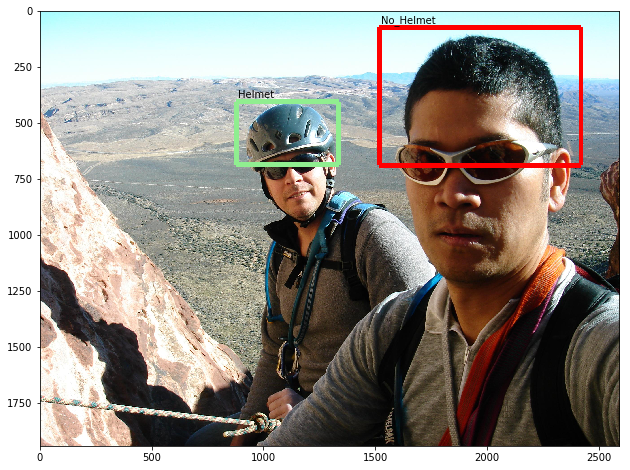

In [13]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.prediction import models
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
%matplotlib inline

# Now there is a trained endpoint that can be used to make a prediction
test_img_file = "safety_images/483245.JPG"
test_img = Image.open(test_img_file)
test_img_h, test_img_w, test_img_ch = np.array(test_img).shape
    
predictor = CustomVisionPredictionClient(PREDICTION_KEY, endpoint=ENDPOINT)

# Open the sample image and get back the prediction results.
with open(test_img_file, mode="rb") as test_data:
    results = predictor.predict_image(project.id, test_data, iteration.id)
    


# Display the results.
plt.figure(figsize=(12, 8))
draw = ImageDraw.Draw(test_img)
lineWidth = int(np.array(test_img).shape[1]/120)
color = 'lightgreen'
for prediction in results.predictions:
    if (prediction.probability*100) > 50:  
        if prediction.tag_id == nohelmet_tag.id:
            color = 'red'
        left = prediction.bounding_box.left * test_img_w 
        top = prediction.bounding_box.top * test_img_h 
        height = prediction.bounding_box.height * test_img_h
        width =  prediction.bounding_box.width * test_img_w
        points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
        draw.line(points, fill=color, width=lineWidth)
        plt.annotate(prediction.tag_name,(left+10,top-20))
        
plt.imshow(test_img)
